In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import dill
import h5py
import plotly.express as px
import scipy

sys.path.append("../helper_functions/")
sys.path.append("../objects/")
sys.path.append("../uniform_points_generation/")

from conversions import convert2mainSI
from Aquarium import Aquarium
from Aquarium_SinglePlane import SinglePlaneAquarium
from Fish_Capsule import CapsuleFish
from Worm_SmallSpherical import SmallSphericalWorm

# 3D visualization of whole system

In [3]:
aquarium = SinglePlaneAquarium(
    conductivity=(100, "u", "c.-1"),  # 100 uS/cm
    relative_permittivity=80.0,  # relative permittivity of water
    fish_objs=[],  # empty, will populate later
    worm_objs=[],  # empty, will populate later
    boundaries=[
        ("plane", dict(normal=[0, 0, 1], central_point=[0, 0, 0]))
    ],  # planar boundary marking the bottom of tank
    _init_tests=False,
)

eod_wave_form = np.genfromtxt("../../efish-receptors-model/data/eod-waveform/eod-waveform-fitted.csv", delimiter=",")

fish_chin = CapsuleFish(
    receptors_init=dict(
        method="grid_uniDense",
        head_t=0,
        head_u=0,
        tail_t=0,
        tail_u=0,
        body_t=14,
        body_u=30,
    ),
    eod_wave_form=eod_wave_form,
    skin_resistivity=(3, "k", "c.2"),  # 3 kOhm.cm^2
    sampling_rate=(2.5, "M"),  # MHz
    nose_position=([0, 0, 0], "c"),  # cm
    fish_length=(15, "c"),  # cm
    angle_pitch=(0, "deg"),
    relative_bend_locations_percentage=np.array([]),
    relative_bend_angle_lateral=(np.array([]), "deg"),
    relative_bend_angle_dorso_ventral=(np.array([]), "deg"),
    point_currents_range_percentage=dict(start=0, end=100),
    N_point_currents=101,
    point_currents_magnitude_scale=1,
    vertical_semi_axis=(0.2, "c"),  # cm
    lateral_semi_axis=(0.1, "c"),  # cm
    rostrocaudal_semi_axis=(0, "c"),  # cm
    rostrocaudal_semi_axis_tail=(13, "c"),  # cm
)

fish = CapsuleFish(
    receptors_init=dict(
        method="grid_uniDense",
        head_t=28,
        head_u=30,
        tail_t=28,
        tail_u=20,
        body_t=28,
        body_u=20,
    ),
    eod_wave_form=eod_wave_form,
    skin_resistivity=(3, "k", "c.2"),  # 3 kOhm.cm^2
    sampling_rate=(2.5, "M"),  # MHz
    nose_position=([0, 0, 0], "c"),  # cm
    fish_length=(15, "c"),  # cm
    angle_pitch=(0, "deg"),
    relative_bend_locations_percentage=np.array([]),
    relative_bend_angle_lateral=(np.array([]), "deg"),
    relative_bend_angle_dorso_ventral=(np.array([]), "deg"),
    point_currents_range_percentage=dict(start=1, end=99),
    N_point_currents=101,
    point_currents_magnitude_scale=1,
    vertical_semi_axis=(2, "c"),  # cm
    lateral_semi_axis=(0.9, "c"),  # cm
    rostrocaudal_semi_axis=(3, "c"),  # cm
    rostrocaudal_semi_axis_tail=(8, "c"),  # cm
)

receptors_chin = fish_chin.get_receptors_locations()
receptors_chin[:, 0] += 0.02

receptors_body = fish.get_receptors_locations()
receptors_id_to_keep = np.abs(receptors_body[:, 2]) > 1e-10

receptors = np.vstack((receptors_chin, receptors_body[receptors_id_to_keep]))
normals = np.vstack([fish_chin.get_receptors_normals(), fish.get_receptors_normals()[receptors_id_to_keep]])

fish.update_receptors(receptors, normals)
fish.update_parameters(
    nose_position=([0, 0, 2.1], "c"),
    relative_bend_locations_percentage=np.array([45, 75]),
    relative_bend_angle_lateral=(np.array([-25, -30]), "deg"),
    relative_bend_angle_dorso_ventral=(np.array([10, 10]), "deg"),
)

worm = SmallSphericalWorm(
    center_position=([-2, 2, 2], "c"),
    radius=(1, "c"),  # 1 cm
    resistance=(10, "k"),  # 10 kOhm
    capacitance=(10, "n"),  # 10 nF
)

aquarium.insert_fish(fish)
aquarium.insert_worm(worm)

Success!
Success!
Success!


In [4]:
# fig = aquarium.visualize_aquarium(
#     time_points=50,
#     shown_time_prefix="u",
#     range_points=30,
#     min_ranges=([-16, -5, -4.5], "c"),
#     max_ranges=([4, 10, 10], "c"),
#     lengths_prefix="m",
#     show_fish=20,
#     show_electric_signal=True,
#     show_normals=False,
#     show_point_currents=10,
#     show_image_currents=10,
#     show_worms=1.25,
#     show_potential=True,
#     show_field=False,
#     include_active_objects=True,
#     include_passive_objects=True,
#     electric_signal_perturbation_only=True,
#     potential_double_sided_percentile=10,
#     xaxis_title="X",
#     yaxis_title="Y",
#     zaxis_title="Z",
#     # fig_width=1000,
#     # fig_height=1000,
# )

In [5]:
# camera_eye = np.array([1.25, 0.5, 0.25]) * 1.1
# camera = dict(
#     up=dict(x=0, y=0, z=1),
#     center=dict(x=0, y=-0.13, z=-0.13),
#     eye=dict(x=camera_eye[0], y=camera_eye[1], z=camera_eye[2]),
# )
# fig.update_layout(scene_camera=camera, width=10000, height=10000)
# fig.show()

# Feature space visualizations

## 3D visualization

###  for distance scaling

In [6]:
dataset = dill.load(open("../data/processed/data-2024_06_05-R_and_C_feature_space/dataset.pkl", "rb"))
leods = h5py.File("../data/processed/data-2024_06_05-R_and_C_feature_space/leods.hdf5", "r")["leods"][:]  # type: ignore
responses = h5py.File("../data/processed/data-2024_06_05-R_and_C_feature_space/responses.hdf5", "r")["responses"][:]  # type: ignore

eis = dataset["electric_images"]["pert"]
aquas = dataset["aquarium"]["dataframe"]
worms = dataset["worms"]["dataframe"]
main_df = eis.join(aquas[["conductivities"]].reset_index(names="aqua_id"), on="aqua_id", rsuffix="_R").join(
    worms[["resistances", "capacitances", "position_ys"]].reset_index(names="worm_id"), on="worm_id", rsuffix="_R"
)

feats_bias = np.array([-5000, 5000])
base_feats = dataset["electric_images"]["base"][dataset["electric_images"]["base"]["aqua_id"] == 1]["responses"].iloc[
    0
][1]
feats = responses[main_df[(main_df["aqua_id"] == 1)].index][:, 1]  # type: ignore
feats = ((feats + feats_bias) / (base_feats + feats_bias) - 1) * 100
dists = (
    dataset["worms"]["position_ys"][main_df[(main_df["aqua_id"] == 1)]["position_ys"]]
    - dataset["worms"]["radii"][0]
    - dataset["fish"]["dataframe"]["objs"][0].get_lateral_semi_axis()
)
plot_df = pd.DataFrame(np.vstack([feats.T, dists]).T, columns=["mz", "dlz", "distance"])  # type: ignore
# plot_df["distance_color"] = plot_df["distance"]
plot_df["distance_color"] = main_df[(main_df["aqua_id"] == 1)]["position_ys"].to_numpy()

In [1]:
# fig = px.scatter_3d(
#     plot_df[plot_df["distance"] < 0.02],
#     x="mz",
#     y="dlz",
#     z="distance",
#     color="distance_color",
#     color_continuous_scale=px.colors.qualitative.T10,
# )
# fig.update_traces(marker_size=4, opacity=1)
# camera_eye = np.array([1, -1.5, 1.5]) * 0.9
# camera = dict(
#     up=dict(x=0, y=0, z=1),
#     center=dict(x=0, y=0, z=0),
#     eye=dict(x=camera_eye[0], y=camera_eye[1], z=camera_eye[2]),
# )
# fig.update_layout(
#     scene_camera=camera,
#     width=1500,
#     height=1500,
#     scene=dict(
#         xaxis=dict(
#             backgroundcolor="rgb(220, 220, 240)",
#             gridcolor="white",
#             showbackground=True,
#             zerolinecolor="grey",
#             zerolinewidth=3,
#         ),
#         yaxis=dict(
#             backgroundcolor="rgb(240, 220, 240)",
#             gridcolor="white",
#             showbackground=True,
#             zerolinecolor="grey",
#             zerolinewidth=3,
#         ),
#         zaxis=dict(
#             backgroundcolor="rgb(240, 240, 220)",
#             gridcolor="white",
#             showbackground=True,
#             zerolinecolor="grey",
#             zerolinewidth=3,
#         ),
#     ),
# )
# fig.show()

In [8]:
dists[:11]

array([0.005, 0.006, 0.007, 0.008, 0.009, 0.01 , 0.012, 0.014, 0.016,
       0.018, 0.021])

In [9]:
plot_df_2d = pd.DataFrame(
    np.vstack(
        [
            feats.T,
            dists,
            dataset["worms"]["resistances"][main_df[(main_df["aqua_id"] == 1)]["resistances"]],
            dataset["worms"]["capacitances"][main_df[(main_df["aqua_id"] == 1)]["capacitances"]],
            np.log10(dataset["worms"]["resistances"][main_df[(main_df["aqua_id"] == 1)]["resistances"]]),
            np.log10(dataset["worms"]["capacitances"][main_df[(main_df["aqua_id"] == 1)]["capacitances"]]),
            main_df[(main_df["aqua_id"] == 1)]["resistances"],
            main_df[(main_df["aqua_id"] == 1)]["capacitances"],
        ]
    ).T,
    columns=[
        "mz",
        "dlz",
        "distance",
        "resistance",
        "capacitance",
        "resistance_log",
        "capacitance_log",
        "resistance_id",
        "capacitance_id",
    ],
)  # type: ignore
plot_df_2d = plot_df_2d[np.abs(plot_df_2d["distance"] - 0.005) < 1e-15]
plot_df_2d = plot_df_2d[plot_df_2d["resistance_id"] % 4 == 0]
plot_df_2d = plot_df_2d[plot_df_2d["capacitance_id"] % 4 == 0]
plot_df_2d.shape

(169, 9)

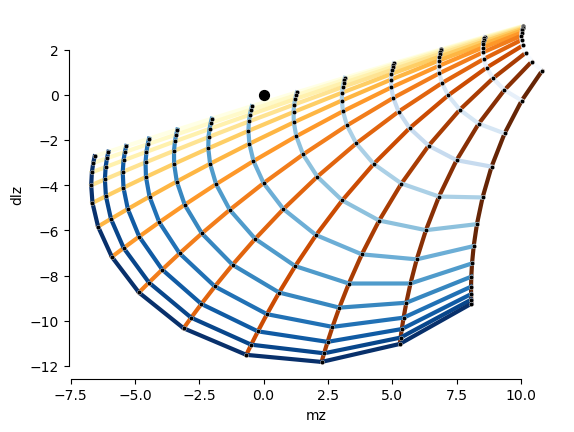

In [10]:
sns.scatterplot(data=plot_df_2d, x="mz", y="dlz", s=10, c="k", zorder=3)

cmap = sns.color_palette("YlOrBr", as_cmap=True)  # plt.cm.crest
cnorm = mpl.colors.Normalize(vmin=plot_df_2d["capacitance_log"].min(), vmax=plot_df_2d["capacitance_log"].max())
for i, res_id in enumerate(plot_df_2d["capacitance_id"].unique()):
    temp = plot_df_2d[plot_df_2d["capacitance_id"] == res_id]
    plt.plot(temp["mz"], temp["dlz"], c=cmap(cnorm(temp["capacitance_log"].iloc[0])), lw=3)

cmap = sns.color_palette("Blues", as_cmap=True)  # plt.cm.flare
cnorm = mpl.colors.Normalize(vmin=plot_df_2d["resistance_log"].min(), vmax=plot_df_2d["resistance_log"].max())
for i, res_id in enumerate(plot_df_2d["resistance_id"].unique()):
    temp = plot_df_2d[plot_df_2d["resistance_id"] == res_id]
    plt.plot(temp["mz"], temp["dlz"], c=cmap(cnorm(temp["resistance_log"].iloc[0])), lw=3)
plt.scatter([0], [0], c="k", s=50, zorder=2)
sns.despine(trim=True)
plt.savefig("./panels/feature_space_2d.svg")
plt.show()

In [11]:
plot_df_2d["capacitance_log"].max()

-8.034672857231348

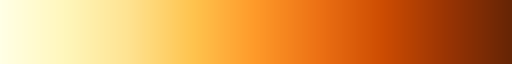

In [12]:
sns.color_palette("YlOrBr", as_cmap=True)

### for size/radius scaling

In [13]:
dataset = dill.load(open("../data/processed/data-2024_06_05-R_and_C_feature_space-radius_scale/dataset.pkl", "rb"))
responses = h5py.File("../data/processed/data-2024_06_05-R_and_C_feature_space-radius_scale/responses.hdf5", "r")["responses"][:]  # type: ignore

eis = dataset["electric_images"]["pert"]
aquas = dataset["aquarium"]["dataframe"]
worms = dataset["worms"]["dataframe"]
main_df = eis.join(aquas[["conductivities"]].reset_index(names="aqua_id"), on="aqua_id", rsuffix="_R").join(
    worms[["resistances", "capacitances", "radii"]].reset_index(names="worm_id"), on="worm_id", rsuffix="_R"
)

feats_bias = np.array([-5000, 5000])
base_feats = dataset["electric_images"]["base"]["responses"].iloc[0][1]
feats = responses[main_df.index][:, 1]  # type: ignore
feats = ((feats + feats_bias) / (base_feats + feats_bias) - 1) * 100
radii = dataset["worms"]["radii"][main_df["radii"]]
plot_df = pd.DataFrame(np.vstack([feats.T, radii]).T, columns=["mz", "dlz", "radius"])  # type: ignore
plot_df["radius_color"] = plot_df["radius"]

In [2]:
# fig = px.scatter_3d(
#     plot_df,
#     x="mz",
#     y="dlz",
#     z="radius",
#     color="radius_color",
#     color_continuous_scale=px.colors.qualitative.T10,
# )
# fig.update_traces(marker_size=4, opacity=1)
# camera_eye = np.array([1, -1.5, 1.5]) * 0.9
# camera = dict(
#     up=dict(x=0, y=0, z=1),
#     center=dict(x=0, y=0, z=0),
#     eye=dict(x=camera_eye[0], y=camera_eye[1], z=camera_eye[2]),
# )
# fig.update_layout(
#     scene_camera=camera,
#     width=1500,
#     height=1500,
#     scene=dict(
#         xaxis=dict(
#             backgroundcolor="rgb(220, 220, 240)",
#             gridcolor="white",
#             showbackground=True,
#             zerolinecolor="grey",
#             zerolinewidth=3,
#         ),
#         yaxis=dict(
#             backgroundcolor="rgb(240, 220, 240)",
#             gridcolor="white",
#             showbackground=True,
#             zerolinecolor="grey",
#             zerolinewidth=3,
#         ),
#         zaxis=dict(
#             backgroundcolor="rgb(240, 240, 220)",
#             gridcolor="white",
#             showbackground=True,
#             zerolinecolor="grey",
#             zerolinewidth=3,
#         ),
#     ),
# )
# fig.show()

In [15]:
radii[:11]

array([0.005, 0.006, 0.007, 0.008, 0.009, 0.01 , 0.011, 0.012, 0.013,
       0.014, 0.005])

## Electric Color Lines

In [28]:
dataset = dill.load(open("../data/processed/data-2024_07_25-electric_color_lines/dataset.pkl", "rb"))
leods = h5py.File("../data/processed/data-2024_07_25-electric_color_lines/leods.hdf5", "r")["leods"][:]  # type: ignore
responses = h5py.File("../data/processed/data-2024_07_25-electric_color_lines/responses.hdf5", "r")["responses"][:]  # type: ignore

eis = dataset["electric_images"]["pert"]
worms = dataset["worms"]["dataframe"]
main_df = eis.join(
    worms[["resistances", "capacitances", "position_ys"]].reset_index(names="worm_id"), on="worm_id", rsuffix="_R"
)

feats_bias = np.array([-5000, 5000])
base_feats = dataset["electric_images"]["base"]["responses"].iloc[0][1]
feats = responses[:, 1]  # type: ignore
feats = ((feats + feats_bias) / (base_feats + feats_bias) - 1) * 100
dists = (
    dataset["worms"]["position_ys"][main_df["position_ys"]]
    - dataset["worms"]["radii"][0]
    - dataset["fish"]["dataframe"]["objs"][0].get_lateral_semi_axis()
)

pppn = leods[:, 1]
pppn_base = dataset["electric_images"]["base"]["leods"].iloc[0][0][1]
pppn = np.array([pppn.ptp(1), pppn.max(1) / pppn.min(1)]).T
pppn_base = np.array([pppn_base.ptp(), pppn_base.max() / pppn_base.min()])
pppn_feats = (pppn / pppn_base - 1) * 100

plot_df = pd.DataFrame(np.vstack([feats.T, pppn_feats.T, dists, main_df["resistances"], main_df["capacitances"]]).T, columns=["mz", "dlz", "pp", "pn", "distance", "R_id", "C_id"])  # type: ignore
plot_df["distance_color"] = plot_df["distance"]

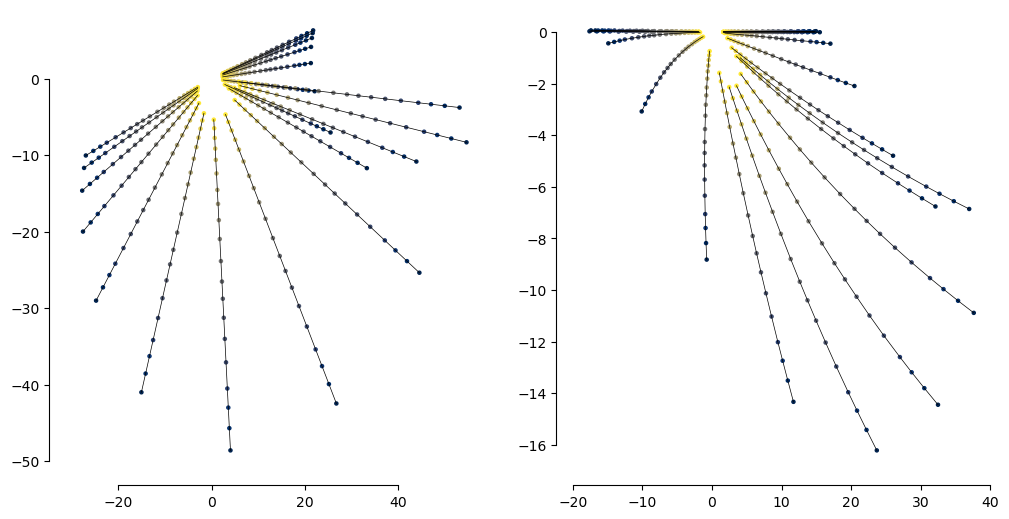

In [29]:
def plot_electric_color_lines(dfgroup, ax_conv, ax_pppn):
    ax_conv.plot(dfgroup["mz"], dfgroup["dlz"], c="k", lw=0.5)
    ax_conv.scatter(dfgroup["mz"], dfgroup["dlz"], c=np.log(dfgroup["distance_color"]), s=5, cmap="cividis")
    ax_pppn.plot(dfgroup["pp"], dfgroup["pn"], c="k", lw=0.5)
    ax_pppn.scatter(dfgroup["pp"], dfgroup["pn"], c=np.log(dfgroup["distance_color"]), s=5, cmap="cividis")

    _, _, r2_conv, _, _ = scipy.stats.linregress(dfgroup["mz"], dfgroup["dlz"])
    _, _, r2_pppn, _, _ = scipy.stats.linregress(dfgroup["pp"], dfgroup["pn"])
    return pd.Series(dict(conv=r2_conv**2, pppn=r2_pppn**2))


f, ax = plt.subplots(1, 2, figsize=(12, 6))
color_line_r2 = (
    plot_df.groupby(["R_id", "C_id"]).apply(lambda x: plot_electric_color_lines(x, ax[0], ax[1])).reset_index()
)
sns.despine(ax=ax[0], offset=10, trim=True)
sns.despine(ax=ax[1], offset=10, trim=True)
plt.savefig("panels/electric_color_lines.svg")
plt.show()

In [18]:
color_line_r2["conv"].mean(), color_line_r2["pppn"].mean()

(0.9999999999987124, 0.9323183398857967)

In [19]:
color_line_r2["conv"].std(), color_line_r2["pppn"].std()

(1.7959535146343942e-12, 0.1560023824362825)

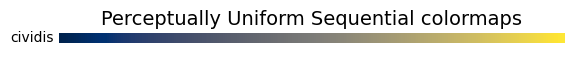

In [20]:
cmaps = {}

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))


def plot_color_gradients(category, cmap_list):
    # Create figure and adjust figure height to number of colormaps
    nrows = len(cmap_list)
    figh = 0.35 + 0.15 + (nrows + (nrows - 1) * 0.1) * 0.22
    fig, axs = plt.subplots(nrows=nrows + 1, figsize=(6.4, figh))
    fig.subplots_adjust(top=1 - 0.35 / figh, bottom=0.15 / figh, left=0.2, right=0.99)
    axs[0].set_title(f"{category} colormaps", fontsize=14)

    for ax, name in zip(axs, cmap_list):
        ax.imshow(gradient, aspect="auto", cmap=mpl.colormaps[name])
        ax.text(-0.01, 0.5, name, va="center", ha="right", fontsize=10, transform=ax.transAxes)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axs:
        ax.set_axis_off()

    # Save colormap list for later.
    cmaps[category] = cmap_list


plot_color_gradients("Perceptually Uniform Sequential", ["cividis"])
plt.savefig("panels/electric_color_line-color_gradients.svg")

In [31]:
aquarium = Aquarium(
    conductivity=(100, "u", "c.-1"),  # 100 uS/cm
    relative_permittivity=80.0,  # relative permittivity of water
    fish_objs=[],  # empty, will populate later
    worm_objs=[],  # empty, will populate later
    _init_tests=False,
)

eod_wave_form = np.genfromtxt("../../efish-receptors-model/data/eod-waveform/eod-waveform-fitted.csv", delimiter=",")

fish_chin = CapsuleFish(
    receptors_init=dict(
        method="grid_uniDense",
        head_t=0,
        head_u=0,
        tail_t=0,
        tail_u=0,
        body_t=14,
        body_u=30,
    ),
    eod_wave_form=eod_wave_form,
    skin_resistivity=(3, "k", "c.2"),  # 3 kOhm.cm^2
    sampling_rate=(2.5, "M"),  # MHz
    nose_position=([0, 0, 0], "c"),  # cm
    fish_length=(15, "c"),  # cm
    angle_pitch=(0, "deg"),
    relative_bend_locations_percentage=np.array([]),
    relative_bend_angle_lateral=(np.array([]), "deg"),
    relative_bend_angle_dorso_ventral=(np.array([]), "deg"),
    point_currents_range_percentage=dict(start=0, end=100),
    N_point_currents=101,
    point_currents_magnitude_scale=1,
    vertical_semi_axis=(0.2, "c"),  # cm
    lateral_semi_axis=(0.1, "c"),  # cm
    rostrocaudal_semi_axis=(0, "c"),  # cm
    rostrocaudal_semi_axis_tail=(13, "c"),  # cm
)

fish = CapsuleFish(
    receptors_init=dict(
        method="grid_uniDense",
        head_t=28,
        head_u=30,
        tail_t=28,
        tail_u=20,
        body_t=28,
        body_u=20,
    ),
    eod_wave_form=eod_wave_form,
    skin_resistivity=(3, "k", "c.2"),  # 3 kOhm.cm^2
    sampling_rate=(2.5, "M"),  # MHz
    nose_position=([0, 0, 0], "c"),  # cm
    fish_length=(15, "c"),  # cm
    angle_pitch=(0, "deg"),
    relative_bend_locations_percentage=np.array([]),
    relative_bend_angle_lateral=(np.array([]), "deg"),
    relative_bend_angle_dorso_ventral=(np.array([]), "deg"),
    point_currents_range_percentage=dict(start=1, end=99),
    N_point_currents=101,
    point_currents_magnitude_scale=1,
    vertical_semi_axis=(2, "c"),  # cm
    lateral_semi_axis=(0.9, "c"),  # cm
    rostrocaudal_semi_axis=(3, "c"),  # cm
    rostrocaudal_semi_axis_tail=(8, "c"),  # cm
)

receptors_chin = fish_chin.get_receptors_locations()
receptors_chin[:, 0] += 0.02

receptors_body = fish.get_receptors_locations()
receptors_id_to_keep = np.abs(receptors_body[:, 2]) > 1e-10

receptors = np.vstack((receptors_chin, receptors_body[receptors_id_to_keep]))
normals = np.vstack([fish_chin.get_receptors_normals(), fish.get_receptors_normals()[receptors_id_to_keep]])

fish.update_receptors(receptors, normals)
fish.update_parameters(
    nose_position=([0, 0, 2.1], "c"),
)

worm = SmallSphericalWorm(
    center_position=([-2, 2, 2], "c"),
    radius=(0.75, "c"),  # 1 cm
    resistance=(2.5, "k"),  # 10 kOhm
    capacitance=(50, "n"),  # 10 nF
)
# worm = SmallSphericalWorm(
#     center_position=([-2, 2, 2], "c"),
#     radius=(1, "c"),  # 1 cm
#     resistance=(10, "k"),  # 10 kOhm
#     capacitance=(10, "n"),  # 10 nF
# )

aquarium.insert_fish(fish)
aquarium.insert_worm(worm)

Success!
Success!
Success!


In [32]:
receptor_id = np.linalg.norm(fish.get_receptors_locations() - worm.get_position(), axis=1).argmin()
# base signal
_, base_electric_signal = aquarium.transdermal_signal_for_all_fish(include_perturbations=False)
signal_base = base_electric_signal[receptor_id]

# live object signal
aquarium.remove_worm(worm)
worm_live = SmallSphericalWorm(
    center_position=([-2, 2, 2], "c"),
    radius=(0.75, "c"),  # 1 cm
    resistance=(2.5, "k"),  # 10 kOhm
    capacitance=(50, "n"),  # 10 nF
)
aquarium.insert_worm(worm_live)
_, electric_signal = aquarium.transdermal_signal_for_all_fish(include_perturbations=True)
electric_signal_live = electric_signal
signal_distorted_live = electric_signal[receptor_id]

# rock/plastic signal
aquarium.remove_worm(worm_live)
worm_rock = SmallSphericalWorm(
    center_position=([-2, 2, 2], "c"),
    radius=(0.75, "c"),  # 1 cm
    resistance=(100, "k"),  # 10 kOhm
    capacitance=(0.0001, "n"),  # 10 nF
)
aquarium.insert_worm(worm_rock)
_, electric_signal = aquarium.transdermal_signal_for_all_fish(include_perturbations=True)
signal_distorted_rock = electric_signal[receptor_id]

# metal object signal
aquarium.remove_worm(worm_rock)
worm_metal = SmallSphericalWorm(
    center_position=([-2, 2, 2], "c"),
    radius=(0.75, "c"),  # 1 cm
    resistance=(1, "k"),  # 10 kOhm
    capacitance=(0.0001, "n"),  # 10 nF
)
aquarium.insert_worm(worm_metal)
_, electric_signal = aquarium.transdermal_signal_for_all_fish(include_perturbations=True)
signal_distorted_metal = electric_signal[receptor_id]

# reset aquarium
aquarium.remove_worm(worm_metal)
aquarium.insert_worm(worm)

Success!
Success!
Success!


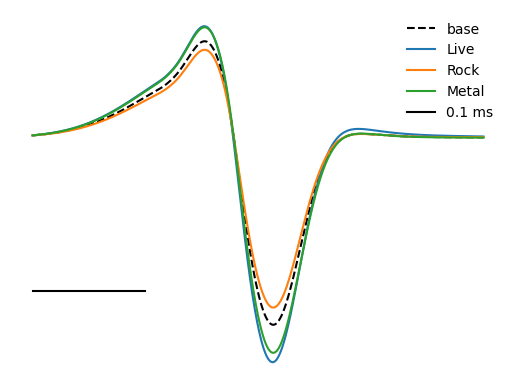

In [33]:
plt.figure()
plt.plot(signal_base, "k--", label="base")
plt.plot(signal_distorted_live, "C0", label="Live")
plt.plot(signal_distorted_rock, "C1", label="Rock")
plt.plot(signal_distorted_metal, "C2", label="Metal")
plt.plot([0, 0.1e-3 * fish.get_sampling_rate()], [-60, -60], "k", label="0.1 ms")
plt.legend(frameon=False)
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.savefig("./panels/3d_visualization_inset.svg")
plt.show()

In [9]:
receptor_filters = pd.read_csv("../../efish-receptors-model/data/filters/fish-filters-0p4.csv").T.to_numpy()
full_EI_live = (((receptor_filters @ electric_signal_live.T) / (receptor_filters @ base_electric_signal.T) - 1) * 100)
print("Max and Min modulations for each zone")
print(full_EI_live.shape, full_EI_live.max(1), full_EI_live.min(1))
print("Modulation at closest receptor")
print(full_EI_live[:,receptor_id])

Max and Min modulations for each zone
(2, 2324) [18.96577155  1.56903248] [-22.61481743  -1.87091694]
Modulation at closest receptor
[18.09498732  1.49699277]


In [10]:
# fish.visualize_scatter(intensity=full_EI_live[0], marker_alpha=1, show_point_currents=0);

In [40]:
# # fig = aquarium.visualize_aquarium(
# #     time_points=[365],
# #     shown_time_prefix="u",
# #     range_points=30,
# #     min_ranges=([-19, -5, -4.5], "c"),
# #     max_ranges=([6, 10, 10], "c"),
# #     lengths_prefix="m",
# #     show_fish=15,
# #     show_electric_signal=True,
# #     show_normals=False,
# #     show_point_currents=False,
# #     show_worms=1.,
# #     show_potential=True,
# #     show_field=False,
# #     include_active_objects=True,
# #     include_passive_objects=True,
# #     electric_signal_perturbation_only=True,
# #     potential_double_sided_percentile=10,
# #     xaxis_title="X",
# #     yaxis_title="Y",
# #     zaxis_title="Z",
# #     # fig_width=1000,
# #     # fig_height=1000,
# # )
# fig = aquarium.visualize_aquarium(
#     time_points=[365],
#     shown_time_prefix="u",
#     range_points=30,
#     min_ranges=([-15, -2.5, -1], "c"),
#     max_ranges=([3, 2.5, 5], "c"),
#     lengths_prefix="m",
#     show_fish=20,
#     show_electric_signal=True,
#     show_normals=False,
#     show_point_currents=False,
#     show_worms=False,
#     show_potential=False,
#     show_field=False,
#     include_active_objects=True,
#     include_passive_objects=True,
#     electric_signal_perturbation_only=True,
#     potential_double_sided_percentile=10,
#     xaxis_title="X",
#     yaxis_title="Y",
#     zaxis_title="Z",
#     # fig_width=1000,
#     # fig_height=1000,
# )

In [13]:
# # camera_eye = np.array([0.85, 1.1, 0.85]) * 1.1
# # camera = dict(
# #     up=dict(x=0, y=0, z=1),
# #     center=dict(x=0, y=-0.13, z=-0.13),
# #     eye=dict(x=camera_eye[0], y=camera_eye[1], z=camera_eye[2]),
# # )
# # fig.update_layout(scene_camera=camera, width=10000, height=10000)
# # fig.write_image("panels/3d-viz.svg")
# # fig.show()

# camera_eye = np.array([0.1, 1.5, 0.5]) * 1.1
# camera = dict(
#     up=dict(x=0, y=0, z=1),
#     center=dict(x=0, y=0, z=0),
#     eye=dict(x=camera_eye[0], y=camera_eye[1], z=camera_eye[2]),
# )
# fig.update_layout(scene_camera=camera, width=10000, height=10000)
# # fig.write_image("panels/electric-image.svg")
# fig.show()

## Feature space variations with size, receptor, sigma, tail, boundary